In [1]:
import json
import os
import plotly.express as px
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
files_name = [file_name for file_name in os.listdir('./all/') if '.json' in file_name]

dictionary = {}

for file in files_name:
    f = open(f'./all/{file}', 'r', encoding='utf-8')
    data = json.loads(f.read())
    f.close()
    data_month = data["metadata-all"]['fr']['month']
    for years in data_month:
        for month in data_month[years]:
            m = month
            if len(month)==1:
                m = '0' + month
            if f'{years}-{m}' in dictionary.keys():
                dictionary[f'{years}-{m}'] += data_month[years][str(month)]["num"]
            else:
                dictionary[f'{years}-{m}'] = data_month[years][str(month)]["num"]


sorted_keys = sorted(dictionary.keys(), reverse = True)
dict_sorted = {key:dictionary[key] for key in sorted_keys}

df = pd.DataFrame(dict_sorted.items(), columns=['Month', 'Nb of Article'])
df = df.sort_index(axis = 0, ascending = False)
print(df)

      Month  Nb of Article
36  2018-12            104
35  2019-01           4023
34  2019-02           3774
33  2019-03           3911
32  2019-04           3683
31  2019-05           3743
30  2019-06           3545
29  2019-07           3847
28  2019-08           3438
27  2019-09           3960
26  2019-10           4187
25  2019-11           3911
24  2019-12           3742
23  2020-01           3695
22  2020-02           3650
21  2020-03           3727
20  2020-04           3391
19  2020-05           3510
18  2020-06           3588
17  2020-07           3596
16  2020-08           3465
15  2020-09           3708
14  2020-10           3669
13  2020-11           3648
12  2020-12           3425
11  2021-01           3674
10  2021-02           3457
9   2021-03           3562
8   2021-04           2898
7   2021-05           2953
6   2021-06           3249
5   2021-07           3217
4   2021-08           3091
3   2021-09           3262
2   2021-10           3554
1   2021-11           3238
0

In [3]:
fig = px.bar(df,x= 'Month', y = 'Nb of Article',color="Nb of Article",color_continuous_scale=px.colors.sequential.matter)
fig.show()

In [4]:
def filterByLocKeyWord(keyWord: str, dicLoc: dict, allLocKey: dict, data_all: dict) -> None:
    for year in data_all:
        for month in data_all[year]:
            for date in data_all[year][month]:
                if keyWord in data_all[year][month][date][0]["loc"]:
                    # print(f'{year}-{month}-{date}')
                    # print(data_all[year][month][date][0]["title"])
                    # print(data_all[year][month][date][0]["loc"])
                    for loc in data_all[year][month][date][0]["loc"]:
                        if  (loc in allLocKey):
                            dicLoc[loc] = dicLoc[loc] + 1


def getLocationKey(allLocKey) -> dict:
    dictLoc = dict.fromkeys(list(allLocKey), 0)
    return dictLoc


def convertTupleToDict(listTuple):
    dico = {}
    for tuple in listTuple:
        dico[tuple[0]] = tuple[1]
    return dico


def cleanDict(dictionary: dictionary) -> dict:    
    keys = list(dictionary.keys())
    for key in keys:
        if dictionary.get(key)==0:
            dictionary.pop(key)
    sortedTuple = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
    return convertTupleToDict(sortedTuple) 

def firstElements(dictionary,nb):
    sortedTuple = sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
    return dict(list(sortedTuple[0: nb]))


In [59]:
listOfDict = [] #liste des dictionnaire des localisations apparaissant dans chaque site lorsque l'on parle de la France
dictionaryLoc = {} #dictionnaire des localisations apparaissant dans tout les sites lorsque l'on parle de la France

for file in os.listdir("all"):
    f = open(f'all/{file}', 'r', encoding='utf-8')
    data = json.loads(f.read())
    f.close()

    allLocKey = data["metadata-all"]["fr"]["all"]["loc"].keys()
    dicLoc = getLocationKey(allLocKey)

    data_all = data["data-all"]
    filterByLocKeyWord('France', dicLoc, allLocKey, data_all)
    listOfDict.append(dicLoc)

    dictionaryLoc = Counter(dictionaryLoc) + Counter(dicLoc)

for d in listOfDict:
    d = cleanDict(d)

toplocation = firstElements(dictionaryLoc, 20)
print(toplocation)

{'France': 637, 'Paris': 97, 'États-Unis': 76, 'État': 70, 'Israël': 42, 'Russie': 36, 'Allemagne': 33, 'Algérie': 26, 'Iran': 26, 'Mali': 23, 'Europe': 22, 'Afrique': 20, 'Chine': 17, 'Royaume-Uni': 17, 'Turquie': 16, 'Alger': 16, 'République': 16, 'Sahel': 15, 'Moscou': 14, 'Italie': 14}


## Création des noeuds
Nous récupérons ici la liste des localisations ainsi que la liste du nombre de fois ou chaque localisation apparait un article.

In [60]:
nodes = list(toplocation.keys())
weight = list(toplocation.values())
print(nodes)
print(weight)

['France', 'Paris', 'États-Unis', 'État', 'Israël', 'Russie', 'Allemagne', 'Algérie', 'Iran', 'Mali', 'Europe', 'Afrique', 'Chine', 'Royaume-Uni', 'Turquie', 'Alger', 'République', 'Sahel', 'Moscou', 'Italie']
[637, 97, 76, 70, 42, 36, 33, 26, 26, 23, 22, 20, 17, 17, 16, 16, 16, 15, 14, 14]


## Création des arcs entre les noeuds
Nous avons décidé de pondérer les arcs par le nombres d'articles où la localisation apparait afin d'obtenir des écarts entre les différents noeuds plus significatif et plus facilement représentables.

In [61]:
edges = [(nodes[0], nodes[k],weight[k]) for k in range(1, len(nodes))]
print(edges)

[('France', 'Paris', 97), ('France', 'États-Unis', 76), ('France', 'État', 70), ('France', 'Israël', 42), ('France', 'Russie', 36), ('France', 'Allemagne', 33), ('France', 'Algérie', 26), ('France', 'Iran', 26), ('France', 'Mali', 23), ('France', 'Europe', 22), ('France', 'Afrique', 20), ('France', 'Chine', 17), ('France', 'Royaume-Uni', 17), ('France', 'Turquie', 16), ('France', 'Alger', 16), ('France', 'République', 16), ('France', 'Sahel', 15), ('France', 'Moscou', 14), ('France', 'Italie', 14)]


## Création du graphe
Nous créons finalement un graphe à partir des noeuds et des arcs créés précédement. Plus une localisation est citée dans des articles en lien avec la localisation centrale, plus elle apparait proche de celle-ci sur le graphe. Nous appliquons finalement un gradiant de couleur pour améliorer la lisibilité du graphe.

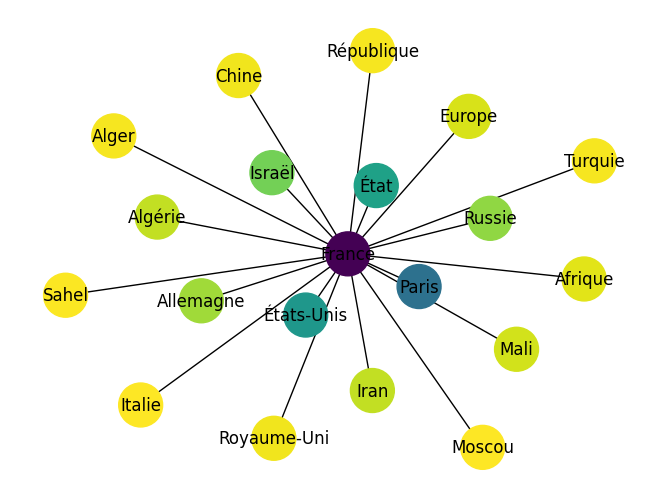

In [63]:
g = nx.Graph()
g.add_weighted_edges_from(edges)
g.add_nodes_from(nodes)
n_weight = [i for i in weight]
n_weight[0] = n_weight[1]+ n_weight[1]/2
nx.draw_spring(g,with_labels=True,node_size = 1000,node_color = n_weight,cmap = plt.cm.get_cmap('viridis_r'))

In [70]:
def filterByLocKeyWord(keyWord: str, dicLoc: dict, allLocKey: dict, data_all: dict) -> None:   
        for year in data_all:
                for month in data_all[year]:
                    for date in data_all[year][month]:
                        if keyWord in data_all[year][month][date][0]["loc"]:
                            print(f'{year}-{month}-{date}')
                            print(data_all[year][month][date][0]["kws"])
                            print(data_all[year][month][date][0]["loc"])
                            for loc in data_all[year][month][date][0]["loc"]:
                                if  (loc in allLocKey):
                                    dicLoc[loc] = dicLoc[loc] + 1
                        
dicLoc ={}
f = open(f'all/{file}', 'r', encoding='utf-8')
data = json.loads(f.read())
f.close()

allLocKey = data["metadata-all"]["fr"]["all"]["loc"].keys()
dicLoc = getLocationKey(allLocKey)

data_all = data["data-all"]
filterByLocKeyWord('France', dicLoc, allLocKey, data_all)


2019-1-12
{'janvier': 15, 'blablacar': 6, 'tolérance': 4, 'politique': 3, 'france': 3, 'bonjour': 2, 'valeur': 2, 'membre': 2, 'dm': 2, 'gauche': 2, 'migrant': 2, 'utilisateur': 2, 'limite': 2, 'bla': 2, 'accord': 2, 'personne': 2, 'opinion': 2, 'désolé': 1, 'communauté': 1, 'partage': 1, 'respect': 1, 'dernier': 1, 'détail': 1, 'florilège': 1, 'réaction': 1, 'twitter': 1, 'cher': 1, 'crain': 1, 'tiers': 1, 'français': 1, 'oeil': 1, 'passager': 1, 'infréquentable': 1, 'paul': 1, 'sugy': 1, 'trajet': 1, 'robin': 1, 'nitot': 1, 'formulaire': 1, 'orientation': 1, 'cgu': 1, '𝕭𝖔𝖓𝖓𝖊': 1, 'opposant': 1, '𝕽𝖊𝖓𝖆𝖚𝖉': 1, '𝕸𝖔𝖓𝖙𝖆𝖚𝖇𝖆𝖓': 1, 'bonsoir': 1, 'régulier': 1, 'application': 1, 'société': 1, 'antoine': 1, 'berth': 1, 'honneur': 1, 'présence': 1, 'sol': 1, 'jérém': 1, 'idée': 1, 'covoiturage': 1, 'zadiste': 1, 'smartphone': 1, 'damien': 1, 'ن': 1, 'part': 1, 'monde': 1, 'réel': 1, 'gars': 1, 'boris': 1, 'guesclin': 1, 'magnifique': 1, 'publicité': 1, 'voiture': 1, 'doigt': 1, 'sujet': 1, 'loi'